This Notebook is to perform EDA on the COVID datasets and to group the data so that it can be compared to the air quality and CO2 data

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats

In [2]:
covid_cases_df = pd.read_csv("./data/raw_data/covid_confirmed_usafacts.csv")
covid_deaths_df = pd.read_csv("./data/raw_data/covid_deaths_usafacts.csv")
county_population = pd.read_csv("./data/raw_data/covid_county_population_usafacts.csv")
census_df = pd.read_csv("./data/raw_data/county_population_census.csv", encoding = "ISO-8859-1")

Take a look at the dataframes


In [3]:
covid_cases_df.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,1787,1791,1798,1805,1818,1828,1831,1839,1852,1863
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,5606,5640,5997,6024,6048,6073,6085,6116,6134,6141
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,886,896,898,902,921,921,921,923,927,927
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,658,664,672,675,678,686,687,691,703,708


In [4]:
covid_deaths_df.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,27,27,27,27,27,27,27,27,27,28
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,50,52,53,53,53,53,53,55,56,64
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,9
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,12


In [5]:
county_population.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


Because our CO2 data is at the state level, we will want some of this data to be grouped by state so it can be spatially compared to the air quality

In [6]:
state_cases_df = covid_cases_df.groupby(by = ["State"]).sum()

#the sum of countyFIPS and stateFIPS is not helpful to us here - let's remove it
state_cases_df.drop(columns = ["countyFIPS", "stateFIPS"], inplace = True)

#Next, we want the State column to be it's own column instead of the row index. 
state_cases_df = state_cases_df.reset_index()


In [7]:
#Do the same thing to the deaths dataframe
state_deaths_df = covid_deaths_df.groupby(by = ["State"]).sum()
state_deaths_df.drop(columns = ["countyFIPS", "stateFIPS"], inplace = True)
state_deaths_df = state_deaths_df.reset_index()

Now we have the number of COVID cases and deaths for each state... but should we really compare the number of cases in California with the number of cases in Montana? Here, I am joining the population data to our state-level COVID dataframes to standardize the counts

In [8]:
#Instead of lookiing at all of the county-level populations,we can just take the state-level because our other data is also at the state level 
state_populations_df = census_df[census_df["STNAME"] == census_df["CTYNAME"]]

#There are two rows of "District of Columbia" with the same values... delete one of them
state_populations_df = state_populations_df.drop(index = 327)

#reindex the dataframe
state_populations_df.reset_index(inplace = True)

Next, we have to merge the state populations onto the COVID dataframes  

Because one dataframe has the state name and the other has the abbreviation, we need to modify the data first  
Map found from Roger Allen's github to save time :)  https://gist.github.com/rogerallen/1583593

In [9]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_populations_df = state_populations_df.replace({"STNAME": us_state_abbrev})

#Let's also drop all of the columns of census data that we don't need...
state_populations_df = state_populations_df[["STNAME", "POPESTIMATE2019"]]

In [10]:
#Merge the data together
state_cases_pop_df = state_cases_df.merge(right = state_populations_df, left_on = ["State"], right_on = ["STNAME"])
state_cases_pop_df = state_cases_pop_df.drop(columns = "STNAME")

In [11]:
#First, we will get a list of all of the columns that we are going to transform - all of the dates with COVID observations
df_cols = list(state_cases_pop_df.columns.values)
df_cols.remove('State')
df_cols.remove('POPESTIMATE2019')

state_cases_pop_df[df_cols] = state_cases_pop_df[df_cols].apply(pd.to_numeric)
#Make a copy that we can modify
state_cases_corrected = state_cases_pop_df.copy(deep = True)


#divide the COVID count in each column by the Population in its row  * 100
#It will represent the COVID cases 
for col in df_cols:
    state_cases_corrected.loc[:, col] = (state_cases_corrected.loc[:, col] / state_cases_corrected.loc[:, "POPESTIMATE2019"]) * 100

This final table shows the percent of the population that has COVID by state 

In [12]:
state_cases_corrected.head()

,State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,POPESTIMATE2019
0,AK,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.069107,1.086058,1.103145,1.122829,1.148528,1.176961,1.195962,1.213596,1.230956,731545
1,AL,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.155072,3.176384,3.195841,3.230145,3.246237,3.257332,3.272893,3.292044,3.303465,4903185
2,AR,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.773441,2.810686,2.842365,2.867151,2.883322,2.897140,2.918281,2.945188,2.987106,3017804
3,AZ,0.0,0.0,0.0,0.0,0.000014,0.000014,0.000014,0.000014,0.000014,...,3.001999,3.011685,3.019255,3.027979,3.032842,3.037211,3.049040,3.057379,3.069236,7278717
4,CA,0.0,0.0,0.0,0.0,0.000005,0.000008,0.000008,0.000010,0.000010,...,2.072561,2.081505,2.092072,2.099188,2.104739,2.114862,2.121690,2.130743,2.140092,39512223


Now that we have standardized the COVID cases data by population, we will do the same thing to the deaths data

In [13]:
#Merge the data together
state_deaths_pop_df = state_deaths_df.merge(right = state_populations_df, left_on = ["State"], right_on = ["STNAME"])
state_deaths_pop_df = state_deaths_pop_df.drop(columns = "STNAME")

In [14]:
#First, we will get a list of all of the columns that we are going to transform - all of the dates with COVID observations
death_df_cols = list(state_deaths_pop_df.columns.values)
death_df_cols.remove('State')
death_df_cols.remove('POPESTIMATE2019')

state_deaths_pop_df[death_df_cols] = state_deaths_pop_df[death_df_cols].apply(pd.to_numeric)
#Make a copy that we can modify
state_deaths_corrected = state_deaths_pop_df.copy(deep = True)


#divide the COVID death count in each column by the Population in its row  * 100
#It will represent the COVID deaths 
for col in death_df_cols:
    state_deaths_corrected.loc[:, col] = (state_deaths_corrected.loc[:, col] / state_deaths_corrected.loc[:, "POPESTIMATE2019"]) * 100

This will show the percent of the population that has died from COVID by state 

In [15]:
state_deaths_corrected.head()

,State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,POPESTIMATE2019
0,AK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007655,0.007792,0.007792,0.007928,0.007928,0.007928,0.007928,0.008065,0.008202,731545
1,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051599,0.051823,0.051987,0.052150,0.052150,0.052150,0.052619,0.053047,0.053781,4903185
2,AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.045364,0.045861,0.046093,0.046623,0.047220,0.047220,0.048678,0.049075,0.049804,3017804
3,AZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.077624,0.077940,0.078214,0.078352,0.078379,0.078407,0.078475,0.078764,0.078901,7278717
4,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.040241,0.040494,0.040739,0.040851,0.040914,0.041000,0.041200,0.041445,0.041633,39512223


Output the data to a csv file


In [16]:
state_cases_corrected.to_csv("./data/covid_case_percentages.csv", index = False)
state_deaths_corrected.to_csv("./data/covid_death_percentages.csv", index = False)

Next, let's look at our Ozone data 

In [17]:
ozone = pd.read_csv("./data/daily_2020_ozone.csv")
ozone.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
0,1,49,9991,44201,1,34.289001,-85.970065,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,38,NaN,-,Sand Mountain,Sand Mountain Alabama Agricultural Experiment ...,Alabama,DeKalb,Crossville,"Fort Payne, AL",2020-05-01
1,1,49,9991,44201,1,34.289001,-85.970065,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,25,NaN,-,Sand Mountain,Sand Mountain Alabama Agricultural Experiment ...,Alabama,DeKalb,Crossville,"Fort Payne, AL",2020-05-01
2,1,49,9991,44201,1,34.289001,-85.970065,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,35,NaN,-,Sand Mountain,Sand Mountain Alabama Agricultural Experiment ...,Alabama,DeKalb,Crossville,"Fort Payne, AL",2020-05-01
3,1,49,9991,44201,1,34.289001,-85.970065,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Sand Mountain,Sand Mountain Alabama Agricultural Experiment ...,Alabama,DeKalb,Crossville,"Fort Payne, AL",2020-05-01
4,1,49,9991,44201,1,34.289001,-85.970065,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,32,NaN,-,Sand Mountain,Sand Mountain Alabama Agricultural Experiment ...,Alabama,DeKalb,Crossville,"Fort Payne, AL",2020-05-01


In [18]:
#only select the columns we are interested in
ozone_observations = ozone.loc[:, ['Arithmetic Mean', 'State Name', 'County Name', 'AQI' ]]
ozone_observations.head()

,Arithmetic Mean,State Name,County Name,AQI
0,0.036529,Alabama,DeKalb,38
1,0.025176,Alabama,DeKalb,25
2,0.031647,Alabama,DeKalb,35
3,0.029941,Alabama,DeKalb,31
4,0.030824,Alabama,DeKalb,32


The data above had an observation for each testing site for every day for January, February, and March in 2020. Let's group that data by county so we can see how the counties' air quality was as a whole in 2020 before COVID hit 

In [19]:
ozone_by_state = ozone_observations.groupby(['State Name', 'County Name']).mean()
ozone_by_state =  ozone_by_state.reset_index()
ozone_by_state.head()

,State Name,County Name,Arithmetic Mean,AQI
0,Alabama,DeKalb,0.030230,31.583333
1,Alabama,Jefferson,0.024297,29.766667
2,Alaska,Denali,0.036942,35.500000
3,Arizona,Cochise,0.037699,39.406780
4,Arizona,Coconino,0.038844,40.662252


In [20]:
#output the data to csv
ozone_by_state.to_csv("./data/ozone_data_clean.csv")

Perhaps the likelihood of dying from COVID is higher where the air quality is poorer? Let's find out 

In [21]:
state_deaths_over_cases = state_cases_corrected.loc[:, ['State', '9/25/20']].merge(on = 'State', right = state_deaths_corrected.loc[:, ['State', '9/25/20']])
state_deaths_over_cases['percent_infected_who_die'] = state_deaths_over_cases['9/25/20_y'] / state_deaths_over_cases['9/25/20_x']
state_deaths_over_cases.head()

,State,9/25/20_x,9/25/20_y,percent_infected_who_die
0,AK,0.991190,0.007108,0.007171
1,AL,3.072493,0.050906,0.016568
2,AR,2.649145,0.041951,0.015836
3,AZ,2.972571,0.076703,0.025804
4,CA,2.034497,0.039297,0.019315


In [22]:
#modify the state name to match our COVID data
ozone_abbrev = ozone_by_state.replace({'State Name': us_state_abbrev})
#Merge the state percentages with the ozone state-level data
state_deaths_air = state_deaths_over_cases.merge(left_on = 'State', right_on = 'State Name', right = ozone_abbrev.loc[:, ['State Name', 'Arithmetic Mean', 'AQI']])

In [23]:
#The above still needs to be continued

Since both our COVID data and our ozone data are at the county-level, let's look closer at these values at the county-level

In [24]:
ozone_abbrev.head()

,State Name,County Name,Arithmetic Mean,AQI
0,AL,DeKalb,0.030230,31.583333
1,AL,Jefferson,0.024297,29.766667
2,AK,Denali,0.036942,35.500000
3,AZ,Cochise,0.037699,39.406780
4,AZ,Coconino,0.038844,40.662252


In [25]:
#let's only take the cumulative cases - in column 9/25/20
covid_cases_county = covid_cases_df.loc[:, ['County Name', 'State', '9/25/20']]

#strip the word 'County' from the county names in the covid data
covid_cases_county['County Name'] = [row.replace(' County', '') for row in covid_cases_county['County Name']]
#Merge the ozone data to the covid cases data
covid_cases_county = covid_cases_county.merge(left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'], right = ozone_abbrev )

covid_deaths_county = covid_deaths_df.loc[:, ['County Name', 'State', '9/25/20']]
#strip the word 'County' from the county names in the covid data
covid_deaths_county['County Name'] = [row.replace(' County', '') for row in covid_deaths_county['County Name']]
#Merge the ozone data to the ovid cases data
covid_deaths_county = covid_deaths_county.merge(left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'], right = ozone_abbrev )

In [26]:
#rename the observation column so that we can merge them together
covid_cases_county = covid_cases_county.rename(columns = {'9/25/20': 'cumulative cases'})
covid_death_county = covid_deaths_county.rename(columns = {'9/25/20': 'cumulative deaths'})

#merge the deaths data and the cases data together
covid_county = covid_cases_county.merge(right = covid_death_county.loc[:, ['cumulative deaths', 'State', 'County Name']], on = ['State', 'County Name'])
#drop the extra state column
covid_county = covid_county.drop(columns = 'State Name')

In [27]:
#calculate the death rate for those infected in each county
covid_county['percent_infected_fatal'] = covid_county['cumulative deaths'] / covid_county['cumulative cases']

In [28]:
covid_county.head()

,County Name,State,cumulative cases,Arithmetic Mean,AQI,cumulative deaths,percent_infected_fatal
0,DeKalb,AL,2406,0.030230,31.583333,21,0.008728
1,Jefferson,AL,19572,0.024297,29.766667,350,0.017883
2,Cochise,AZ,1893,0.037699,39.406780,71,0.037507
3,Coconino,AZ,3985,0.038844,40.662252,134,0.033626
4,Gila,AZ,1287,0.035354,37.439560,56,0.043512


Text(0.5, 1.0, 'COVID Fatality and Air Quality')

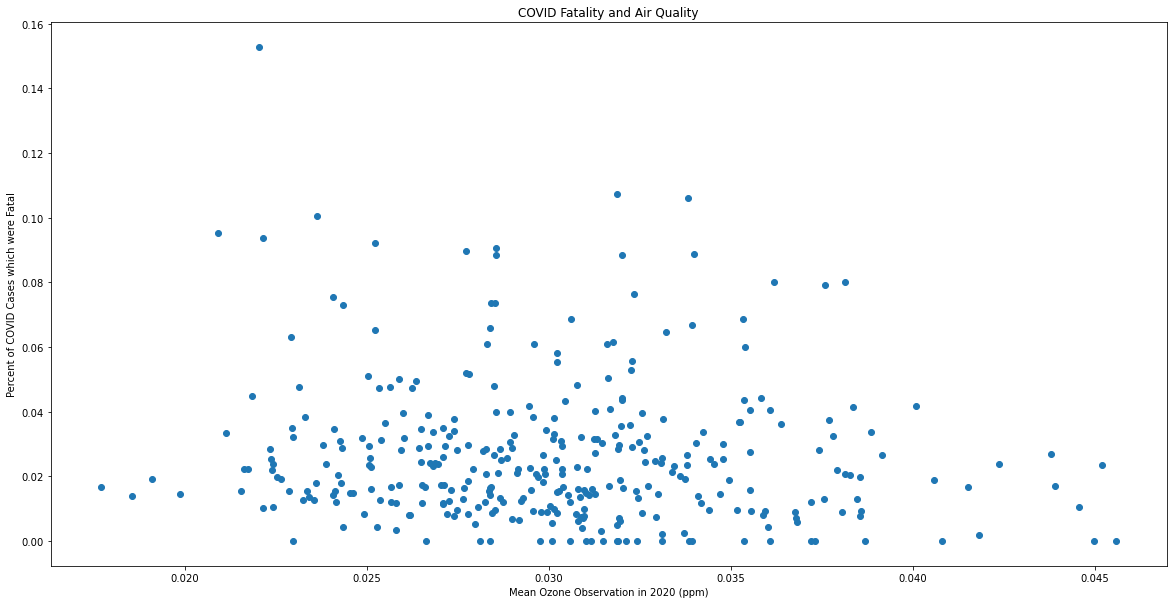

In [29]:
plt.figure(figsize=(20,10))
plt.scatter(covid_county['Arithmetic Mean'], covid_county['percent_infected_fatal'])
plt.xlabel("Mean Ozone Observation in 2020 (ppm)")
plt.ylabel("Percent of COVID Cases which were Fatal")
plt.title("COVID Fatality and Air Quality")



Text(0.5, 1.0, 'COVID Fatality and Air Quality')

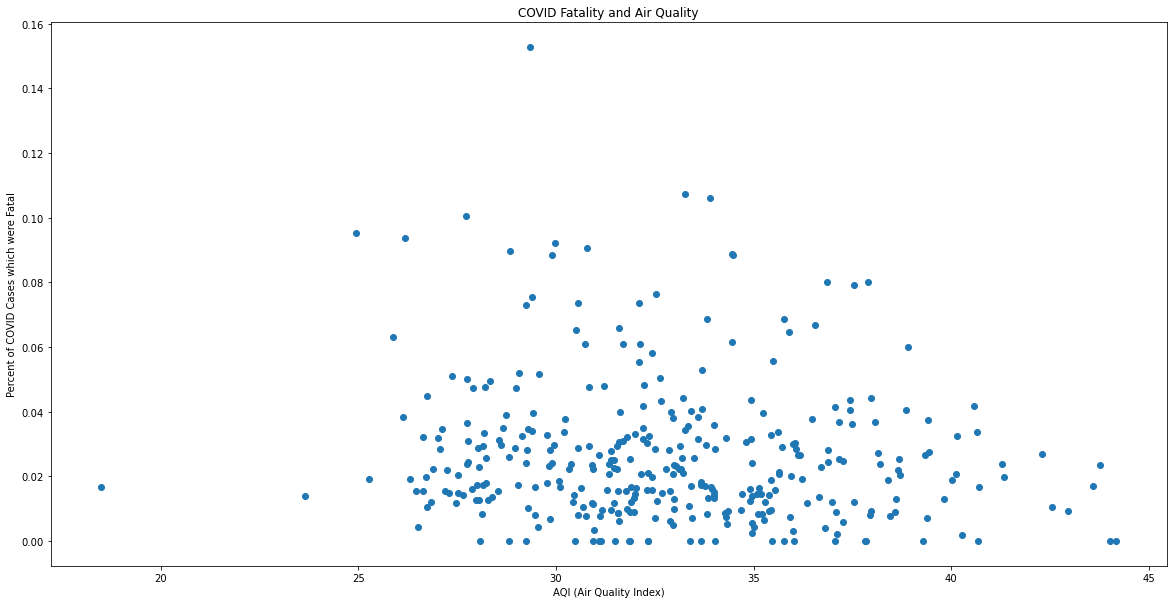

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(covid_county['AQI'], covid_county['percent_infected_fatal'])
plt.xlabel("AQI (Air Quality Index)")
plt.ylabel("Percent of COVID Cases which were Fatal")
plt.title("COVID Fatality and Air Quality")

I imagine that the percent of cases which are fatal would also depend on the average age of the residents...

Now let's look at the chemicals PM2.5, PM10, and NO2 in the air and if they relate to COVID cases

In [31]:
PM25_2018 = pd.read_csv("./data/raw_data/daily_PM2.5/daily_88101_2018.csv")
PM25_2019 = pd.read_csv("./data/raw_data/daily_PM2.5/daily_88101_2019.csv")
PM25_2020 = pd.read_csv("./data/raw_data/daily_PM2.5/daily_88101_2020.csv")

PM10_2018 = pd.read_csv("./data/raw_data/daily_PM10/daily_81102_2018.csv")
PM10_2019 = pd.read_csv("./data/raw_data/daily_PM10/daily_81102_2019.csv")
PM10_2020 = pd.read_csv("./data/raw_data/daily_PM10/daily_81102_2020.csv")

NO2_2018 = pd.read_csv("./data/raw_data/daily_NO2/daily_42602_2018.csv")
NO2_2019 = pd.read_csv("./data/raw_data/daily_NO2/daily_42602_2019.csv")
NO2_2020 = pd.read_csv("./data/raw_data/daily_NO2/daily_42602_2020.csv")

Combine years 2018, 2019 and 2020 and clean the PM2.5 Data

In [32]:
PM25_total = PM25_2018.append(PM25_2019).append(PM25_2020)
PM25_total = PM25_total[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]

#find the mean PM2.5 value over 2018-2020 for each county
PM25_county = PM25_total.groupby(['State Name', 'County Name']).mean()
PM25_county.reset_index(inplace = True)
PM25_county = PM25_county.rename(columns = {'Arithmetic Mean' : 'Mean_PM2.5'})
PM25_county.head()

,State Name,County Name,Mean_PM2.5,AQI
0,Alabama,Baldwin,7.287556,30.035556
1,Alabama,Clay,7.207207,29.770270
2,Alabama,Colbert,7.420635,30.523810
3,Alabama,DeKalb,7.261404,29.929825
4,Alabama,Etowah,7.998739,32.886555


Combine years 2018, 2019, and 2020 and clean the PM10 Data

In [33]:
PM10_total = PM10_2018.append(PM10_2019).append(PM10_2020)
PM10_total = PM10_total[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]

#find the mean PM10 value over 2018-2020 for each county
PM10_county = PM10_total.groupby(['State Name', 'County Name']).mean()
PM10_county.reset_index(inplace = True)
PM10_county = PM10_county.rename(columns = {'Arithmetic Mean' : 'Mean_PM10'})
PM10_county.head()

,State Name,County Name,Mean_PM10,AQI
0,Alabama,Jefferson,20.365941,18.766656
1,Alabama,Madison,13.695699,12.655914
2,Alabama,Montgomery,14.424370,13.285714
3,Alaska,Anchorage,15.725806,14.257143
4,Alaska,Bethel,12.085657,11.039841


Combine years 2018, 2019, and 2020 and clean the NO2 data

In [34]:
NO2_total = NO2_2018.append(NO2_2019).append(NO2_2020)
NO2_total = NO2_total[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]

#find the mean NO2 value over 2018-2020 for each county
NO2_county = NO2_total.groupby(['State Name', 'County Name']).mean()
NO2_county.reset_index(inplace = True)
NO2_county = NO2_county.rename(columns = {'Arithmetic Mean' : 'Mean_NO2'})
NO2_county.head()

,State Name,County Name,Mean_NO2,AQI
0,Alabama,Jefferson,10.467098,21.470468
1,Alaska,Fairbanks North Star,11.071608,19.199313
2,Arizona,Maricopa,16.211190,30.082415
3,Arizona,Pima,7.843879,16.934028
4,Arkansas,Crittenden,7.317950,16.151478


We did some data wrangling of the state-level data, but let's look at the county-level data now. 

To start, we will calculate the percent of people who got COVID that died

In [35]:
percent_died_county = [covid_deaths_df.loc[:, col] / covid_cases_df.loc[:, col] if is_numeric_dtype(covid_cases_df[col]) else covid_cases_df[col] for col in covid_cases_df.columns.values]
percent_died_county = pd.DataFrame(percent_died_county).transpose()
percent_died_county = percent_died_county[['County Name', 'State', '10/8/20']]
percent_died_county.rename(columns = {'10/8/20': 'oct_deaths/cases'}, inplace = True)

In [36]:
percent_died_county

,County Name,State,oct_deaths/cases
0,Statewide Unallocated,AL,NaN
1,Autauga County,AL,0.0150295
2,Baldwin County,AL,0.0104218
3,Barbour County,AL,0.00970874
4,Bibb County,AL,0.0169492
...,...,...,...
3190,Sweetwater County,WY,0.0052356
3191,Teton County,WY,0.00155039
3192,Uinta County,WY,0.00536193
3193,Washakie County,WY,0.0487805


In [37]:
#drop the ones that don't have any data - they aren't helping us
percent_died_county = percent_died_county[percent_died_county['County Name'] != 'Statewide Unallocated']
percent_died_county.loc[:, 'County Name'] = [row.replace(' County', '') for row in percent_died_county['County Name']]

percent_died_county.head()


C:\Users\baile\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,County Name,State,oct_deaths/cases
1,Autauga,AL,0.0150295
2,Baldwin,AL,0.0104218
3,Barbour,AL,0.00970874
4,Bibb,AL,0.0169492
5,Blount,AL,0.00951814


Now let's merge our air data onto this percent deaths data

In [38]:
#rename our environmental state names to the abbreviations 
PM25_county = PM25_county.replace({"State Name": us_state_abbrev})
PM10_county = PM10_county.replace({"State Name": us_state_abbrev})
NO2_county = NO2_county.replace({"State Name": us_state_abbrev})
PM25_county

,State Name,County Name,Mean_PM2.5,AQI
0,AL,Baldwin,7.287556,30.035556
1,AL,Clay,7.207207,29.770270
2,AL,Colbert,7.420635,30.523810
3,AL,DeKalb,7.261404,29.929825
4,AL,Etowah,7.998739,32.886555
...,...,...,...,...
639,WY,Park,3.273129,13.343799
640,WY,Sheridan,6.513791,24.740209
641,WY,Sublette,4.188339,16.746009
642,WY,Sweetwater,4.920084,20.041841


In [39]:
pm25_total_df = percent_died_county.merge(right = PM25_county, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])
pm10_total_df = percent_died_county.merge(right = PM10_county, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])
no2_total_df = percent_died_county.merge(right = NO2_county, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])

Text(0.5, 1.0, 'COVID Fatality Rates and PM2.5 Levels')

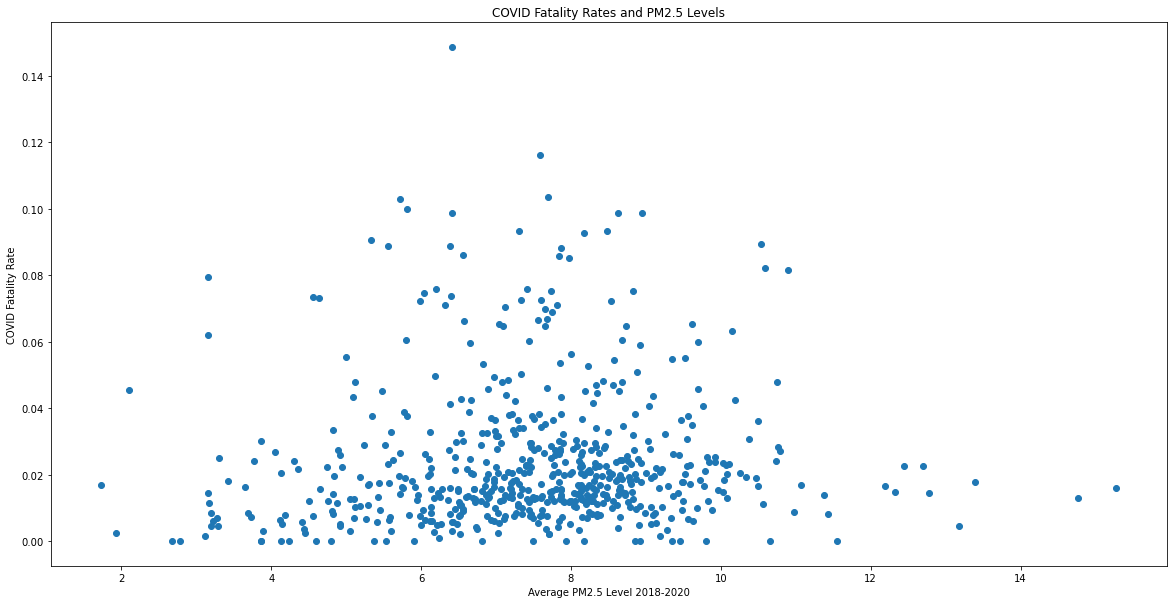

In [40]:
plt.figure(figsize= (20,10))
plt.scatter(pm25_total_df['Mean_PM2.5'], pm25_total_df['oct_deaths/cases'])
plt.xlabel("Average PM2.5 Level 2018-2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and PM2.5 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

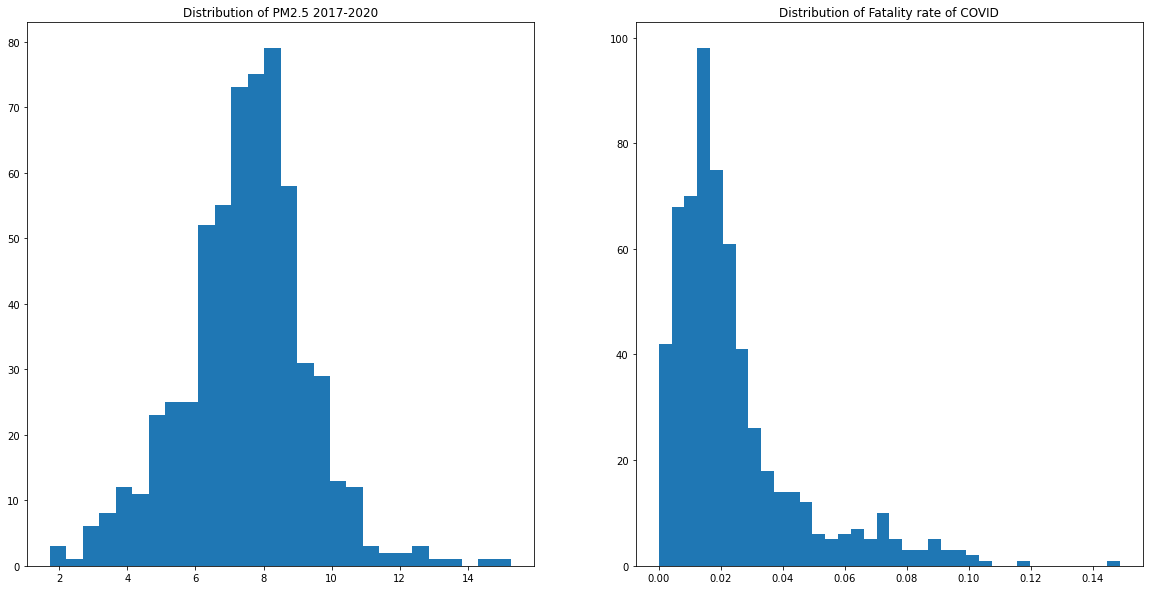

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(pm25_total_df['Mean_PM2.5'], bins = 'auto')
ax1.set_title("Distribution of PM2.5 2017-2020")
ax2.hist(pm25_total_df['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

The COVID fatality data is not normally distributed, so we will use the spearman correlation coefficient

In [53]:
pm25_total_corr = stats.spearmanr(pm25_total_df['Mean_PM2.5'], pm25_total_df['oct_deaths/cases'])
print(pm25_total_corr)

SpearmanrResult(correlation=0.1308791154683056, pvalue=0.0012534433338808495)


There is a statistically significant weak positive correlation between the past 3 years' worth of PM2.5 data and the severity of COVID cases

Text(0.5, 1.0, 'COVID Fatality Rates and PM10 Levels')

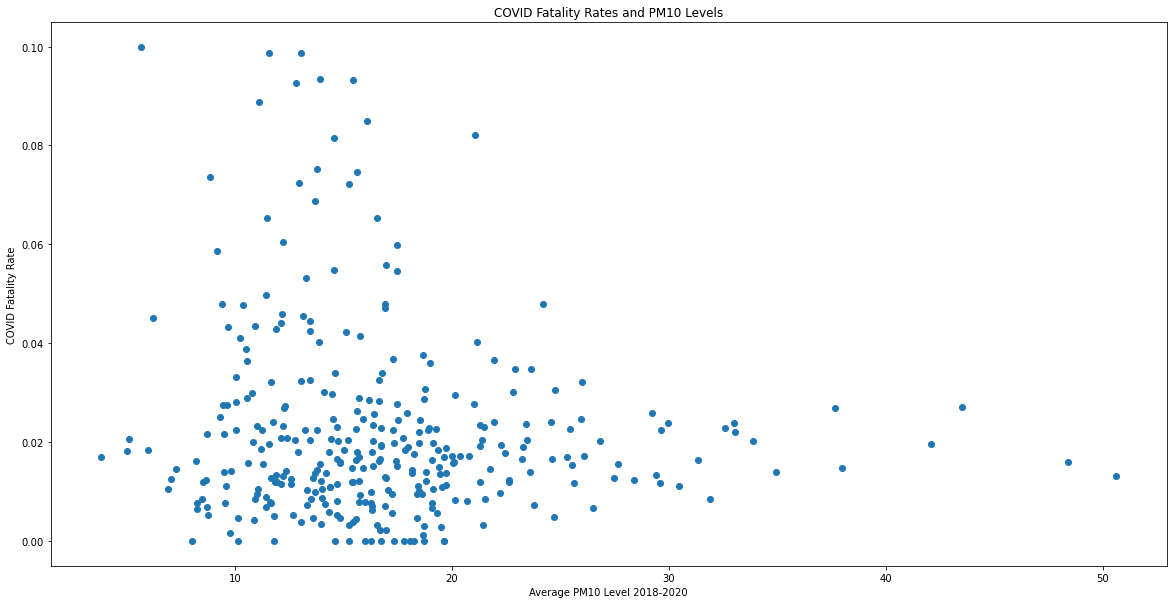

In [43]:
plt.figure(figsize= (20,10))
plt.scatter(pm10_total_df['Mean_PM10'], pm10_total_df['oct_deaths/cases'])
plt.xlabel("Average PM10 Level 2018-2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and PM10 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

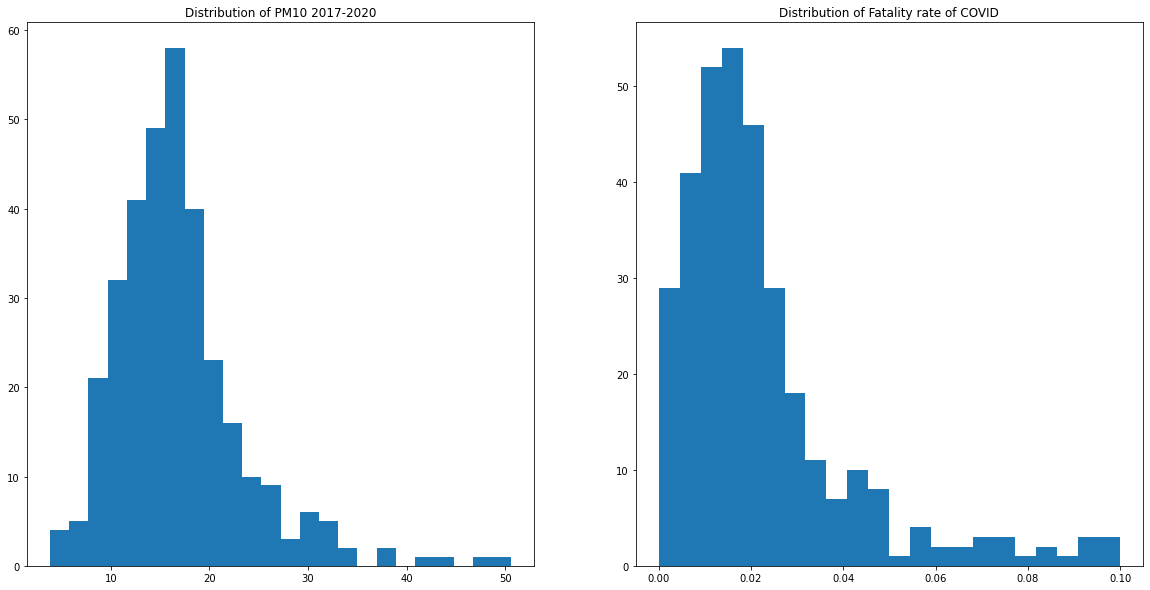

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(pm10_total_df['Mean_PM10'], bins = 'auto')
ax1.set_title("Distribution of PM10 2017-2020")
ax2.hist(pm10_total_df['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

In [84]:
pm10_total_corr = stats.spearmanr(pm10_total_df['Mean_PM10'], pm10_total_df['oct_deaths/cases'])
print(pm10_total_corr)

SpearmanrResult(correlation=-0.0518986185211591, pvalue=0.3472989486045436)


Correlation is not statistically significant for PM10 over the last 3 years

Text(0.5, 1.0, 'COVID Fatality Rates and NO2 Levels')

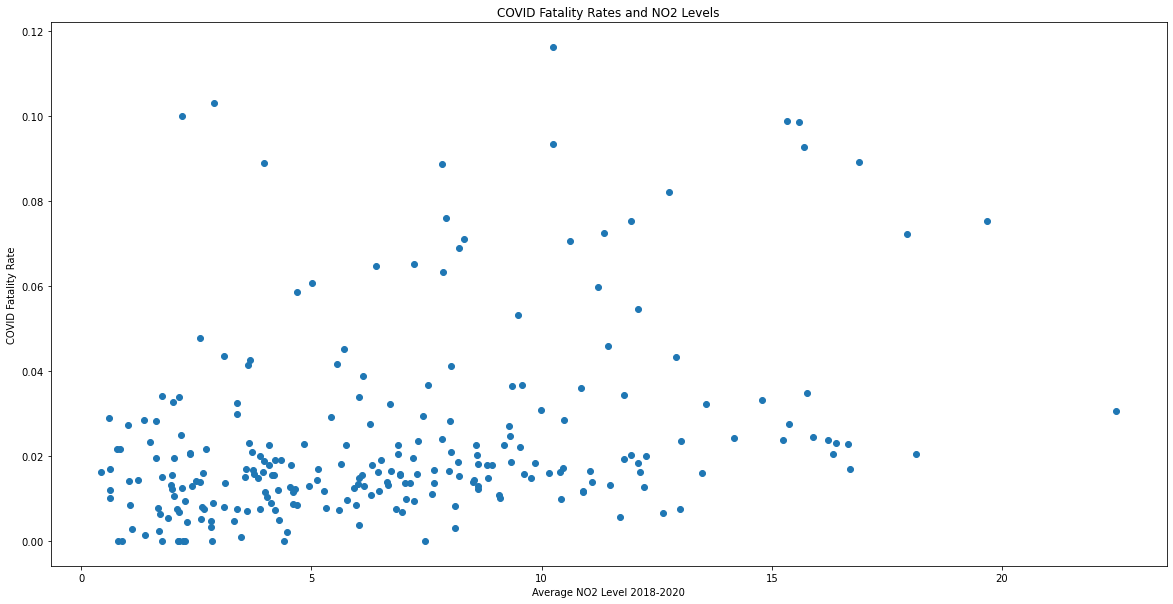

In [231]:
plt.figure(figsize= (20,10))
plt.scatter(no2_total_df['Mean_NO2'], no2_total_df['oct_deaths/cases'])
plt.xlabel("Average NO2 Level 2018-2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and NO2 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

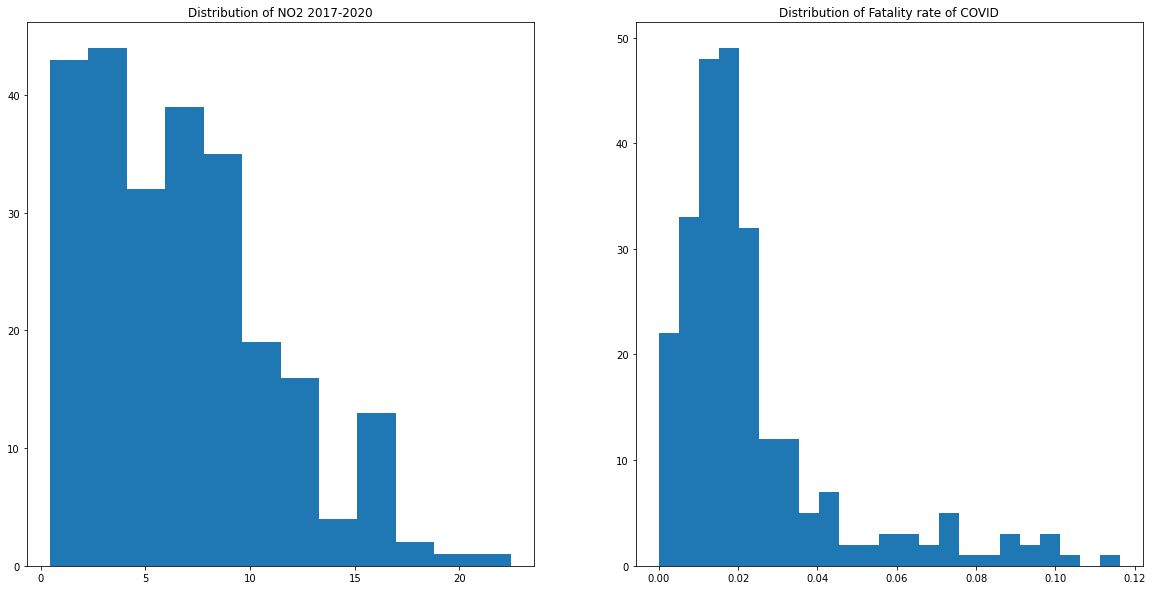

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(no2_total_df['Mean_NO2'], bins = 'auto')
ax1.set_title("Distribution of NO2 2017-2020")
ax2.hist(no2_total_df['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

In [63]:
no2_total_corr = stats.spearmanr(no2_total_df['Mean_NO2'], no2_total_df['oct_deaths/cases'])
print(no2_total_corr)

SpearmanrResult(correlation=0.3773694173562608, pvalue=7.561999594251502e-10)


This one is HIGHLY significant! 

Let's look at this same question, but zoomed in to the air quality since 2020. PM2.5, PM10, and NO2 all stay in the air less than a day, so the more recent data is what really matters

In [68]:
PM25_2020_df = PM25_2020[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]


#find the mean PM2.5 value over 2020 for each county
PM25_2020_df = PM25_2020_df.groupby(['State Name', 'County Name']).mean()
PM25_2020_df.reset_index(inplace = True)
PM25_2020_df = PM25_2020_df.rename(columns = {'Arithmetic Mean' : 'Mean_PM2.5'})
PM25_2020_df.head()

,State Name,County Name,Mean_PM2.5,AQI
0,Alabama,Baldwin,5.972727,24.818182
1,Alabama,Clay,4.160000,17.400000
2,Alabama,DeKalb,5.900000,24.666667
3,Alabama,Etowah,5.900000,24.500000
4,Alabama,Jefferson,8.007725,32.285714


In [69]:
PM10_2020_df = PM10_2020[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]

#find the mean PM10 value over 2020 for each county
PM10_2020_df = PM10_2020_df.groupby(['State Name', 'County Name']).mean()
PM10_2020_df.reset_index(inplace = True)
PM10_2020_df = PM10_2020_df.rename(columns = {'Arithmetic Mean' : 'Mean_PM10'})
PM10_2020_df.head()

,State Name,County Name,Mean_PM10,AQI
0,Alabama,Jefferson,18.431034,16.879310
1,Alabama,Montgomery,10.750000,10.000000
2,Arizona,Apache,9.285714,8.571429
3,Arizona,Cochise,13.269231,12.258242
4,Arizona,Gila,13.919414,12.824176


In [70]:
NO2_2020_df = NO2_2020[['Arithmetic Mean', 'AQI', 'State Name', 'County Name', 'Date Local']]

#find the mean PM10 value over 2020 for each county
NO2_2020_df = NO2_2020_df.groupby(['State Name', 'County Name']).mean()
NO2_2020_df.reset_index(inplace = True)
NO2_2020_df = NO2_2020_df.rename(columns = {'Arithmetic Mean' : 'Mean_NO2'})
NO2_2020_df.head()

,State Name,County Name,Mean_NO2,AQI
0,Alabama,Jefferson,12.966146,23.112903
1,Arizona,Maricopa,18.369909,30.754464
2,Arkansas,Crittenden,7.289488,15.967033
3,Arkansas,Pulaski,8.204746,18.098901
4,California,Riverside,2.820523,7.225806


In [71]:
#rename our environmental state names to the abbreviations 
PM25_2020_df = PM25_2020_df.replace({"State Name": us_state_abbrev})
PM10_2020_df = PM10_2020_df.replace({"State Name": us_state_abbrev})
NO2_2020_df = NO2_2020_df.replace({"State Name": us_state_abbrev})

pm25_post_covid = percent_died_county.merge(right = PM25_2020_df, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])
pm10_post_covid = percent_died_county.merge(right = PM10_2020_df, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])
no2_post_covid = percent_died_county.merge(right = NO2_2020_df, left_on = ['State', 'County Name'], right_on = ['State Name', 'County Name'])

Text(0.5, 1.0, 'COVID Fatality Rates and PM2.5 Levels')

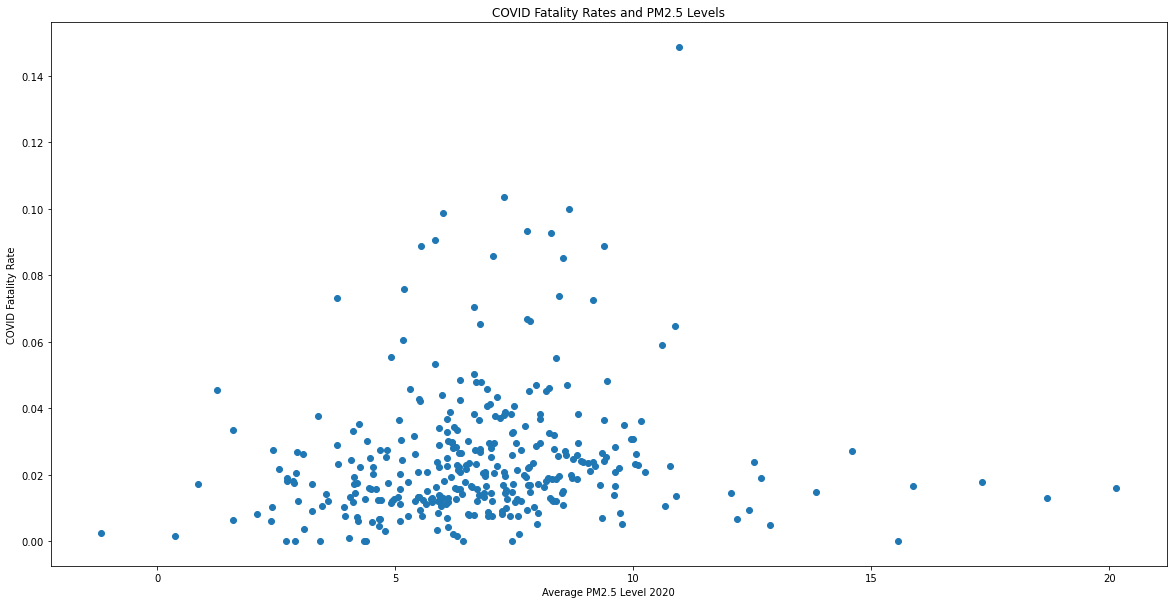

In [72]:
plt.figure(figsize= (20,10))
plt.scatter(pm25_post_covid['Mean_PM2.5'], pm25_post_covid['oct_deaths/cases'])
plt.xlabel("Average PM2.5 Level 2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and PM2.5 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

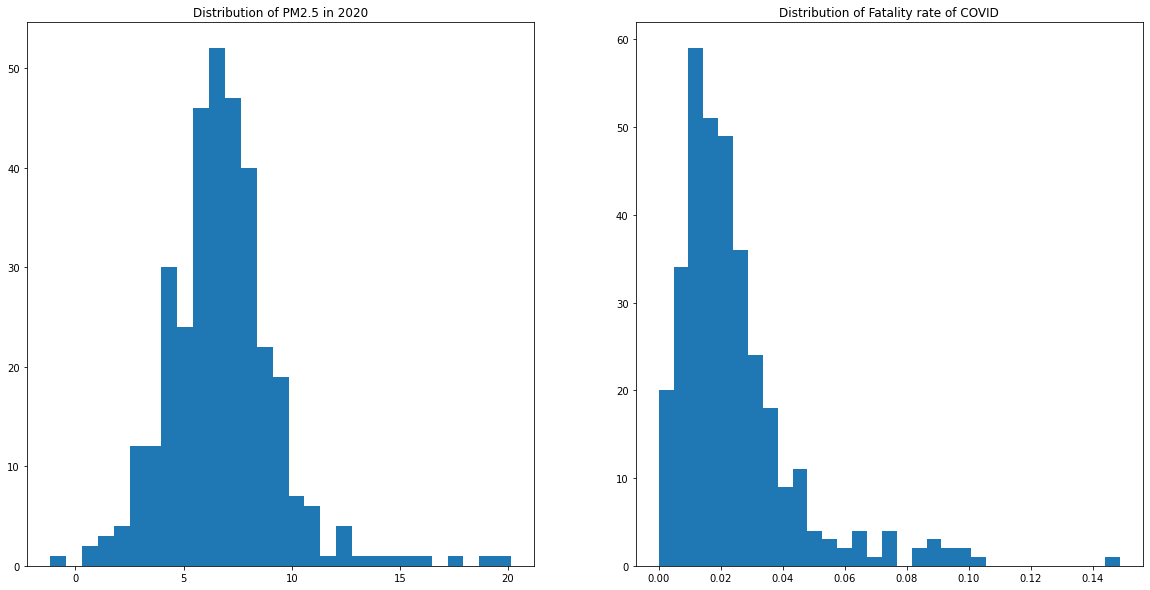

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(pm25_post_covid['Mean_PM2.5'], bins = 'auto')
ax1.set_title("Distribution of PM2.5 in 2020")
ax2.hist(pm25_post_covid['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

In [80]:
pm25_2020_corr = stats.spearmanr(pm25_post_covid['Mean_PM2.5'], pm25_post_covid['oct_deaths/cases'])
print(pm25_2020_corr)

SpearmanrResult(correlation=0.21140429523579196, pvalue=8.557187560820302e-05)


The correlation between 2020 PM2.5 and covid severity is statistically significant, with a weak positive correlation

Text(0.5, 1.0, 'COVID Fatality Rates and PM2.5 Levels')

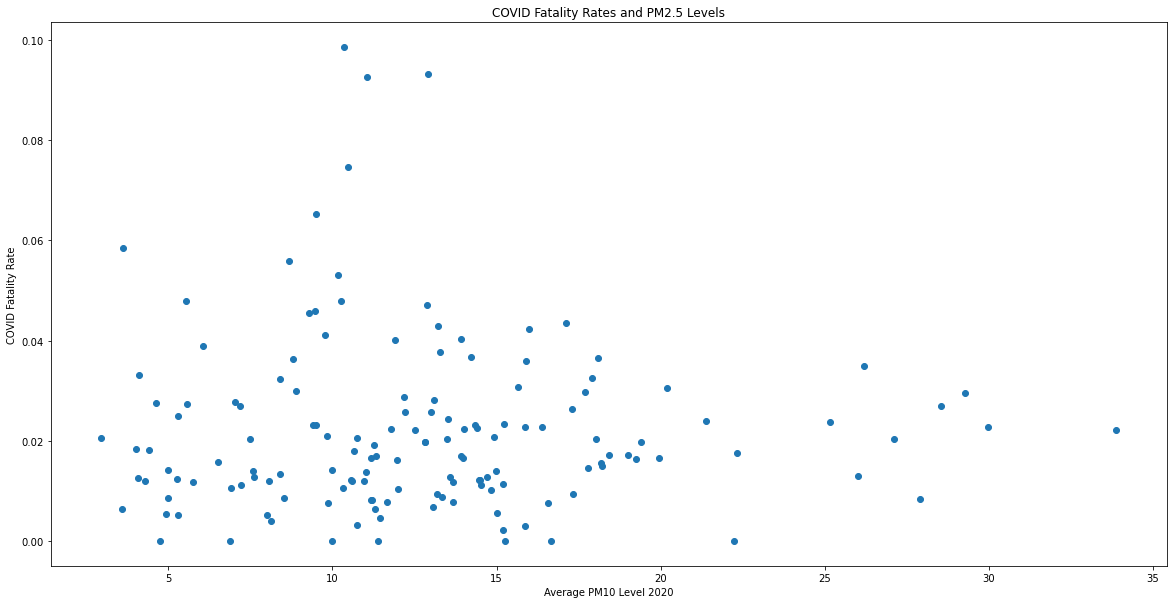

In [261]:
plt.figure(figsize= (20,10))
plt.scatter(pm10_post_covid['Mean_PM10'], pm10_post_covid['oct_deaths/cases'])
plt.xlabel("Average PM10 Level 2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and PM10 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

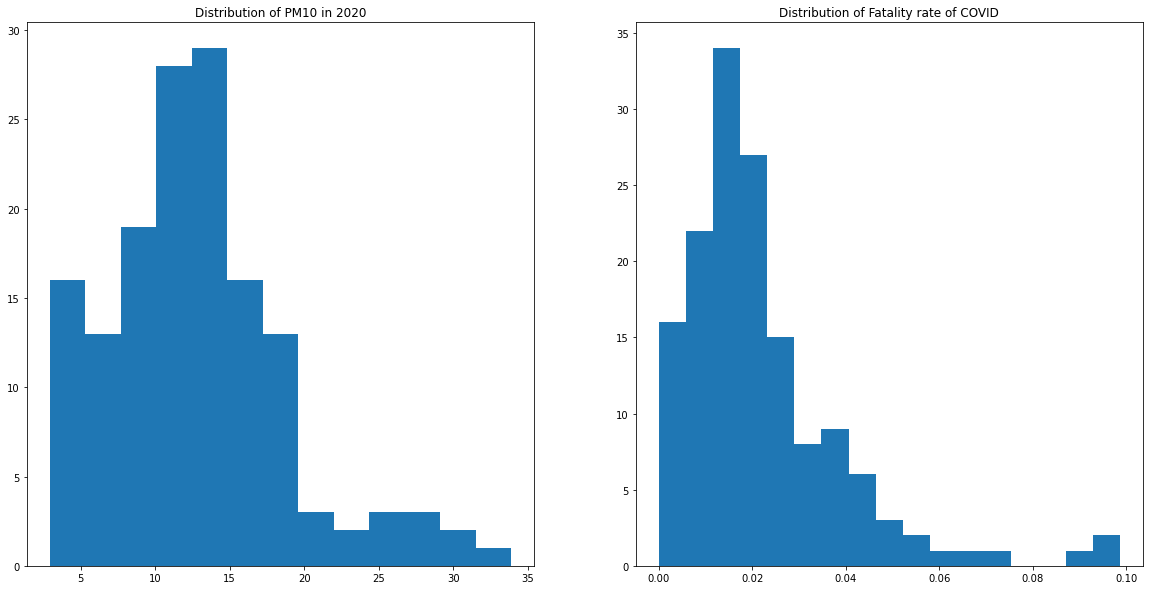

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(pm10_post_covid['Mean_PM10'], bins = 'auto')
ax1.set_title("Distribution of PM10 in 2020")
ax2.hist(pm10_post_covid['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

In [81]:
pm10_2020_corr = stats.spearmanr(pm10_post_covid['Mean_PM10'], pm10_post_covid['oct_deaths/cases'])
print(pm10_2020_corr)

SpearmanrResult(correlation=0.04548125900741794, pvalue=0.5830767339661478)


the correlation between PM10 levels in 2020 and covid severity is not significant

Text(0.5, 1.0, 'COVID Fatality Rates and NO2 Levels')

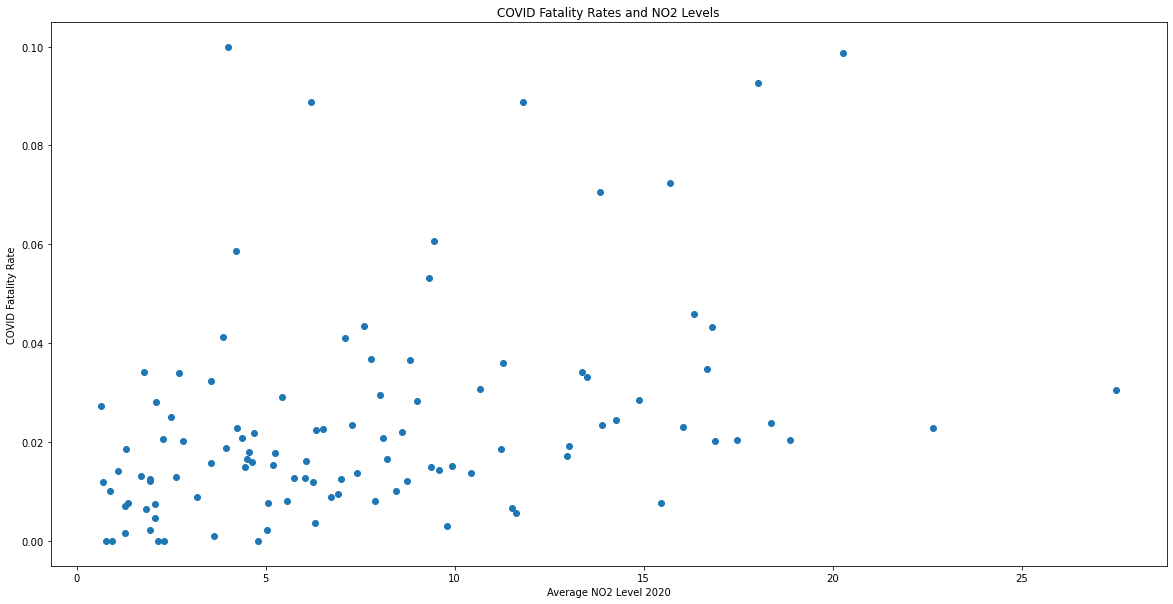

In [263]:
plt.figure(figsize= (20,10))
plt.scatter(no2_post_covid['Mean_NO2'], no2_post_covid['oct_deaths/cases'])
plt.xlabel("Average NO2 Level 2020")
plt.ylabel("COVID Fatality Rate")
plt.title("COVID Fatality Rates and NO2 Levels")

Text(0.5, 1.0, 'Distribution of Fatality rate of COVID')

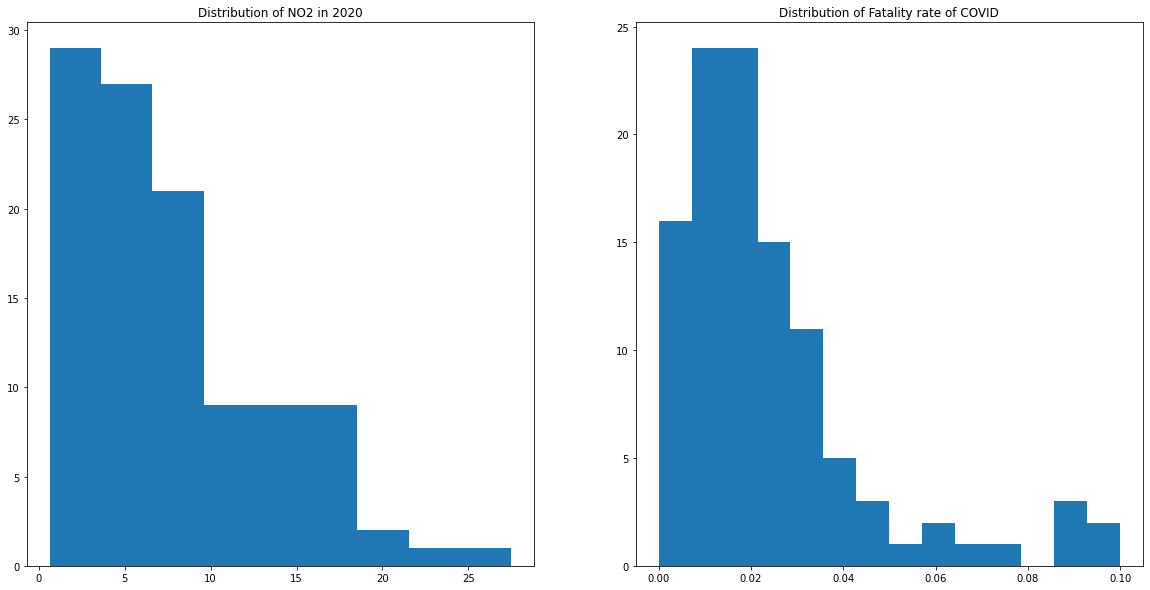

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.hist(no2_post_covid['Mean_NO2'], bins = 'auto')
ax1.set_title("Distribution of NO2 in 2020")
ax2.hist(no2_post_covid['oct_deaths/cases'], bins = 'auto')
ax2.set_title("Distribution of Fatality rate of COVID")

In [83]:
no2_2020_corr = stats.spearmanr(no2_post_covid['Mean_NO2'], no2_post_covid['oct_deaths/cases'])
print(no2_2020_corr)

SpearmanrResult(correlation=0.4376631547809837, pvalue=2.1735903840855208e-06)


The correlation between 2020 NO2 levels and severity of covid is significant!

In summary:  

PM2.5:   
* The correlation between average county PM2.5 levels over the past 3 years and severity of COVID cases is a weak, positive, statistically significant correlation. The correlation coefficient is 0.131 with a  pvalue of 0.0013.  
* The correlation between average county PM2.5 levels in 2020 and severity of COVID cases is a weak, positive, highly statistically significant correlation. The correlation coefficient is 0.211 with a  pvalue of 8.557 * 10 ^ -05

  
PM10:  
* The correlation between PM10 levels and severity of COVID cases is not significant over the last 3 years or in 2020.

  
NO2:   
* The correlation between average county NO2 levels over the past 3 years and COVID severity is a medium, positive, statistically significant correlation The correlation coefficient is 0.377 with a pvalue of 7.56 * 10 ^ -10  
* The correlation between average county NO2 levels in 2020 alone and COVID severity is a medium, positive, statistically significant correlation. The correlation coefficient is 0.438 with a pvalue of 2.17 * 10 ^ -6
